## Imports

In [1]:
#List of imports

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import hmmlearn as hmm

import urllib.request
import zipfile
import cvxpy as cp
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import itertools
import random

random.seed(50)

## Additions below
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
from tqdm.notebook import tqdm
import warnings; warnings.simplefilter('ignore')

## Class Definitions

In [25]:
class Data:
    #Anything Data Related
    def __init__(self, stock_prices, risk_free, universe=None, period='M'):
        #TO-DO: Add initialization of market cap
        
        if not universe:
            universe = stock_prices.columns
            
        if type(universe[0]) == int:
            self.stock_prices = stock_prices.iloc[:,universe]

        else:
            self.stock_prices = stock_prices[universe]
        
        self.risk_free = risk_free
        self.risk_free.index = pd.to_datetime(self.risk_free.index)
        self.risk_free = self.risk_free.resample(period).last()
        
        self.stock_prices.index= pd.to_datetime(self.stock_prices.index)
        
        self.factor_returns=None
        self.stock_returns=self.get_stock_returns()
        
        return
    
    def get_stock_returns(self, period='M'):
        price = self.stock_prices.resample(period).last()

        # Calculate the percent change
        ret_data = price.pct_change()[1:]

        # Convert from series to dataframe
        ret_data = pd.DataFrame(ret_data)

        return ret_data

    def set_factor_returns(self, factor_type='FF', period='M'):
        if factor_type == 'CAPM':
            self.factor_returns = self.get_CAPM_returns(period)
        
        elif factor_type == 'FF':
            self.factor_returns = self.get_FF_returns(period)
            
        elif factor_type == 'Carhart':
            self.factor_returns = self.get_Carhart_returns(period)
            
        elif factor_type == 'PCA':
            self.factor_returns = self.get_PCA_returns(period)
        
        else:
            print("Invalid input: Please select one of the following factor types: CAPM, FF, Carhart or PCA.")
        
        return   
    
    def get_FF_returns(self, period='M'):
        ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"    
        # Download the file and save it  
        urllib.request.urlretrieve(ff_url,'fama_french.zip')
        zip_file = zipfile.ZipFile('fama_french.zip', 'r')    
        # Extact the file data
        zip_file.extractall()
        zip_file.close()    
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)   
        # Skip null rows
        ff_row = ff_factors.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)

        # Format the date index
        ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')

        # Format dates to end of month
        ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()

        # Resample the data to correct frequency
        ff_factors = ff_factors.resample(period).last()

        # Convert from percent to decimal
        ff_factors = ff_factors.apply(lambda x: x/ 100)

        return ff_factors
    
    def get_CAPM_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)
        
        # Remove the unnecessary factors
        capm_factors = ff_factors.iloc[:, 0]
        
        return capm_factors
    
    def get_Carhart_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)

        # Get the momentum factor
        momentum_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"

        # Download the file and save it  
        urllib.request.urlretrieve(momentum_url,'momentum.zip')
        zip_file = zipfile.ZipFile('momentum.zip', 'r')

        # Extact the file data
        zip_file.extractall()
        zip_file.close()

        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, index_col = 0)

        # Skip null rows
        row = momentum_factor.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, nrows = row, index_col = 0)

        # Format the date index
        momentum_factor.index = pd.to_datetime(momentum_factor.index, format= '%Y%m')

        # Format dates to end of month
        momentum_factor.index = momentum_factor.index + pd.offsets.MonthEnd()

         # Resample the data to correct frequency
        momentum_factor = momentum_factor.resample(period).last()

        # Convert from percent to decimal
        momentum_factor = momentum_factor.apply(lambda x: x/ 100)

        # Combine to create the carhart_factors
        carhart_factors = pd.concat([ff_factors, momentum_factor], axis=1).dropna()

        return carhart_factors
    
    def get_PCA_returns(self, period='M'):
        exRets = self.get_stock_returns(period="D")
        num_stocks = len(exRets.columns)
        returns_mat = exRets.to_numpy()
        n_dates = returns_mat.shape[0]
        n_assets = returns_mat.shape[1]
        
        demeaned = (returns_mat - returns_mat.mean(axis=0)).transpose()
        sigma = 1/(n_dates - 1)*np.matmul(demeaned,demeaned.transpose())
        eigval, eigvec = np.linalg.eig(sigma)
        
        principal_components = np.matmul(eigvec.transpose(),demeaned).transpose()
        pca_factors = np.real(principal_components[:,0:100])
        
        pca_df = pd.DataFrame(pca_factors, index = exRets.index, columns = [str(i) for i in range(num_stocks)])
        pca_df = pca_df.resample(period).last()
        
        return pca_df
    
    def get_index_from_date(self, date_index_df, date):
        return date_index_df.index.get_loc(date)
    
    def get_lookback_data(self, date_index_df, date, lookback):
        end_idx= self.get_index_from_date(date_index_df, date)
        return date_index_df.iloc[end_idx-lookback:end_idx]      
    
    def get_num_stocks(self):
        return len(self.stock_returns.columns)

    
class Portfolio:
    #Anything Portfolio related: weights, returns, date-stamped
    def __init__(self, data):       
        num_stocks=data.get_num_stocks()
        self.weights= np.array([[0]*num_stocks + [1]]) # 0 weight on stock
        self.returns= np.array([])
        self.dates= []
        return
        
    def update_weights(self, new_weights):
        
        new_weights = np.expand_dims(new_weights, axis=0)
        self.weights = np.append(self.weights, new_weights, axis=0)
        return
     
    def update_returns(self, new_returns):
        self.returns=np.append(self.returns, new_returns)
        return

    def update_dates(self, new_dates):
       
        self.dates.append(new_dates)
        return
        
    def get_Sharpe(self, data):
        risk_free = data.risk_free
        recent_date = self.dates[-1]
        sigma = np.std(self.returns - np.array(risk_free.loc[self.dates]))
        sharpe_ratio = ((np.prod(1+self.returns)-1) - np.array(risk_free.loc[recent_date]))/sigma
        return sharpe_ratio
        
    def plot(self):
        port_cumu_returns = np.array([x+1 for x in self.returns]).cumprod()
        plt.figure(figsize=(12,6))
        plt.plot(self.dates, port_cumu_returns)
        plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.show()
    
class Costs:
    def __init__(self, trans_coeff, holding_coeff):
        self.holding_cost = 0
        self.trans_cost = 0
        self.trans_coeff = trans_coeff
        self.holding_coeff = holding_coeff
        return
        
    def replicate_cost_coeff(self, num_stocks, lookahead):
        trans_cost_repl = np.ones((num_stocks,lookahead))/100
        holding_cost_repl = np.ones((num_stocks, lookahead))/100
        self.trans_coeff = trans_cost_repl*self.trans_coeff
        self.holding_coeff = holding_cost_repl*self.holding_coeff
        return
    
    def set_holding_cost(self, weights_new):
        self.holding_cost += cp.sum(cp.multiply(self.holding_coeff, cp.neg(weights_new)))
        return
        
    def calc_trans_cost(self, weights_new, weights_old, trans_coeff):
        abs_trade= cp.abs(weights_new-weights_old)
        return cp.sum(cp.multiply(trans_coeff, abs_trade))       
    
    
    def set_trans_cost(self, weights_new, weights_old):
        weights_curr= weights_new[:,0]
        if weights_new.shape[1]>1:         
            weights_future = weights_new[:,1:]
            weights_future_shift = weights_new[:,:-1]
            self.trans_cost = self.calc_trans_cost(weights_future, weights_future_shift, self.trans_coeff[:,1:])

        self.trans_cost += self.calc_trans_cost(weights_curr, weights_old,self.trans_coeff[:,0])
        return


class Constraints:
        #List of all constraints
        def __init__(self, constr_list=['cardinality','asset_limit_cardinality','no_short'], 
                     upper_limit=0.3, lower_limit=-0.3, stock_limit=15):
            self.upper_limit = upper_limit
            self.lower_limit = lower_limit
            self.stock_limit = stock_limit
            self.constr_list = constr_list
            self.value=[]

        
        def set_constraints(self, all_weights, y, cvar=False, gamma=None, z=None, r=None):
            # Set weight unity
            weights=all_weights[:-1,:]
            self.value += [cp.sum(all_weights,axis=0)==1]
            self.value += [all_weights[-1,:]>=0]
            
            if cvar:
                self.value += [z >= 0]
                self.value += [z >= -r.T@all_weights-gamma]
            
            if "cardinality" in self.constr_list:
                self.value+= [cp.sum(y,axis=0)== self.stock_limit]   
                
            if "no_short" in self.constr_list:
                self.value+=  [weights>=0]
                
            if "asset_limit_cardinality" in self.constr_list:
                cardinality_upper_limit= cp.multiply(self.upper_limit, y)
                cardinality_lower_limit = cp.multiply(self.lower_limit,y)
                self.value += [weights>=cardinality_lower_limit, weights<=cardinality_upper_limit]

            elif "asset_limit" in self.constr_list:
                self.value += [weights<=self.upper_limit, weights>=self.lower_limit]
        
            return


class Risks:
    def __init__(self, risk_type="MVO", conf_lvl=0):
        self.value=0
        self.return_adj=0
        self.risk_type=risk_type
        self.conf_lvl=conf_lvl
        return
        
    def set_risk(self, weights, Q, lookahead=1, S=5000, gamma=None, z=None, alpha=None):
        portfolio_risk=0
        robustness_cost=0
        num_stocks = weights.shape[1]
        
        for i in range(lookahead):
            portfolio_risk += cp.quad_form(weights[:,i], Q[i])        
        self.value = portfolio_risk
        
        if self.risk_type == "rect":
            
            for i in range(lookahead):
                delta = stats.norm.ppf(self.conf_lvl)*np.sqrt(np.diag(Q[i]/num_stocks))
                robustness_cost += delta@cp.abs(weights[:,i])
            self.return_adj= robustness_cost
        
        elif self.risk_type == "ellip":
            
            for i in range(lookahead):
         
                penalty = cp.norm(np.sqrt(np.diag(Q[i]/num_stocks))@weights[:,i],2)
                robustness_cost += stats.chi2.ppf(self.conf_lvl, num_stocks)*penalty
            self.return_adj += robustness_cost
            
        elif self.risk_type == "cvar":
            if not S or not gamma or not z or not alpha:
                print("Missing one of these required inputs for CVaR optimization: S, gamma, z, alpha")
                return
            
            self.value = gamma + (1/((1-alpha)*S))*cp.sum(z)
            
        
        elif self.risk_type == 'B-L':
            self.value = 0
            pass
    
        return

    def get_RP_objective(self, weights, args):
        Q = args[0]
        assets_risk_budget = args[1]
        lookahead = args[2]
        cost_model = args[3]
        
        num_stocks = len(assets_risk_budget)

        self.value=0
        # We convert the weights to a matrix
        weights = np.matrix(weights)
        for i in range(lookahead):
            # We calculate the risk of the weights distribution

            portfolio_risk = np.sqrt((weights[0,num_stocks*i:num_stocks*(i+1)] * Q[i] 
                                      * weights[0,num_stocks*i:num_stocks*(i+1)].T))[0, 0]

            # We calculate the contribution of each asset to the risk of the weights
            # distribution
            assets_risk_contribution = np.multiply(weights[0,num_stocks*i:num_stocks*(i+1)].T, Q[i] 
                                                   * weights[0,num_stocks*i:num_stocks*(i+1)].T)/ portfolio_risk

            # We calculate the desired contribution of each asset to the risk of the
            # weights distribution
            assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

            # Error between the desired contribution and the calculated contribution of
            # each asset
            self.value += np.sum(np.square(assets_risk_contribution - assets_risk_target.T))
            
            # Get the holding costs
            self.value += np.sum(cost_model.holding_coeff[0,0]*weights[0,num_stocks*i:num_stocks*(i+1)])
            
            # Get the transaction costs
            if i < lookahead-1:
                abs_trade = np.abs(weights[0, num_stocks*i:num_stocks*(i+1)]-
                                   weights[0, num_stocks*(i+1):num_stocks*(i+2)])
                self.value += np.sum(cost_model.trans_coeff[0,0]*abs_trade)
            
        # It returns the calculated error
        return self.value 
    
    
    
class Model:
    def __init__(self, lam):
        self.opt_weights = 0
        self.status = None
        self.lam = lam

        return
        
    def MVO(self, port, mu , Q, rf, look_ahead, constr_model, cost_model, risk_model):
        
        mu_np = np.array(mu)
        Q_np = np.array(Q)
        
        num_stocks = port.weights.shape[1]-1
        
        #Construct optimization problem
        all_weights = cp.Variable((num_stocks+1,look_ahead))   
        y = cp.Variable((num_stocks,look_ahead), boolean=True)
        
        weights_prev= port.weights[-1,:-1]   
        weights=all_weights[:-1,:]

        # Set model parameters
        cost_model.set_trans_cost(weights, weights_prev)
        cost_model.set_holding_cost(weights)    
        constr_model.set_constraints(all_weights, y)
        risk_model.set_risk(weights, Q,look_ahead)

        # Get portfolio return
        portfolio_return_per_period = mu_np@weights
        rf_return = cp.sum(rf*all_weights[-1,:])
        portfolio_return = cp.trace(portfolio_return_per_period)+rf_return 
        
        
        objective= cp.Maximize(portfolio_return-risk_model.return_adj)
        constr_model.value+= [risk_model.value/look_ahead<=self.lam]
        
        #Construct Problem and Solve
        prob= cp.Problem(objective, constr_model.value)
        result=prob.solve(solver="GUROBI")
        self.status= prob.status
        if self.status == "optimal":
            self.opt_weights=np.array(all_weights.value)[:,0]
           
            print("return_adj:", risk_model.return_adj.value)
            print("port return:",portfolio_return.value)
            print("risk value:",risk_model.value.value)
            print("holding cost:",cost_model.holding_cost.value)
            print("trans cost:", cost_model.trans_cost.value)
    
        else:
            print("Unsolvable, use old weights")
            self.opt_weights=port.weights[-1].T
     
        return self.opt_weights
    
    def BL(self):
        return


    def risk_parity(self, port, Q, lookahead, risk_model, cost_model):
        TOLERANCE = 1e-7
        Q_np =np.array(Q)
        num_stocks=port.weights.shape[1]-1

        #Construct optimization problem
        init_weights = np.tile(port.weights[-1,:-1],lookahead).astype(float)
        init_rf = port.weights[-1,-1]
        weight_total = 1-init_rf
        
        if np.count_nonzero(init_weights)==0:
            init_weights = np.array([1/num_stocks]*num_stocks*lookahead)
            weight_total=1
            init_rf = 0
        
        # The desired contribution of each asset to the portfolio risk: we want all
        # assets to contribute equally
        assets_risk_budget = [1/num_stocks] * num_stocks

        # Optimisation process of weights
        # Restrictions to consider in the optimisation: only long positions whose
        # sum equals 100%
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - weight_total},
                       {'type': 'ineq', 'fun': lambda x: x})

        # Optimisation process in scipy
        optimize_result = minimize(fun=risk_model.get_RP_objective,
                                   x0=init_weights,
                                   args=[Q, assets_risk_budget, lookahead, cost_model],
                                   method='SLSQP',
                                   constraints=constraints,
                                   tol=TOLERANCE,
                                   options={'disp': False, 'maxiter':5000}
                                  )

        # Recover the weights from the optimised object
        weights = np.array(optimize_result.x) 
        
        self.opt_weights = np.concatenate((weights[0:num_stocks], np.array([init_rf])))
        return self.opt_weights        

    def CVaR(self, port, mu , Q, rf, constr_model, cost_model, risk_model):
        mu_np = np.array(mu)[0,:]
        mu_np = np.expand_dims(mu_np, axis=0)
        Q_np = np.array(Q)
        
        num_stocks = port.weights.shape[1]-1
        num_simulations = 5000
        alpha = 0.95
        
        #Construct optimization problem
        all_weights = cp.Variable((num_stocks+1,1)) #x  
        z = cp.Variable((num_simulations,1)) 
        g = cp.Variable(1) 
        
        y = cp.Variable((num_stocks,1), boolean=True)
        
        weights_prev= port.weights[-1,:-1]   
        weights=all_weights[:-1,:]
        print(weights)
        
        # Get r
        r = np.random.randn(num_stocks, 5000)*0.05
        
        # Add risk-free rate to r      
        r = np.concatenate((r, rf*np.ones((1, 5000))), axis=0)
        print(r.shape)

        # Set model parameters
        cost_model.set_trans_cost(weights, weights_prev)
        cost_model.set_holding_cost(weights)    
        constr_model.set_constraints(all_weights, y, cvar=True, gamma=g, z=z, r=r)
        
        risk_model.set_risk(weights, Q, S=5000, gamma=g, z=z, alpha=alpha)
        
        # Get portfolio return
        
        portfolio_return_per_period = mu_np@weights
        rf_return = cp.sum(rf*all_weights[-1])
        portfolio_return = cp.trace(portfolio_return_per_period)+rf_return
        
        objective= cp.Minimize(risk_model.value)
        constr_model.value+= [portfolio_return>=self.lam]
        
        #Construct Problem and Solve
        prob= cp.Problem(objective, constr_model.value)
        result=prob.solve(solver="GUROBI")
        self.status= prob.status
        if self.status == "optimal":
            self.opt_weights=np.array(all_weights.value)[:,0]
            print("port value period:", portfolio_return_per_period.value)
            print("port return:",portfolio_return.value)
            print("risk value:",risk_model.value.value)
            print("holding cost:",cost_model.holding_cost.value)
            print("trans cost:", cost_model.trans_cost.value)
    
        else:
            print("Unsolvable, use old weights")
            self.opt_weights=port.weights[-1].T
     
        return self.opt_weights
    
    
class Backtest:
    def __init__(self, start_date, end_date, lookback, lookahead, period='M'):
        self.rebal_freq = period
        self.start_date = start_date
        self.end_date = end_date
        self.lookback = lookback
        self.lookahead = lookahead
        self.reb_dates = None
        return
        
    
    def run(self, data, portfolio, factor_model, optimizer, constr_model, cost_model, risk_model):      
        stock_return= data.stock_returns      
        self.reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)    
        
        for t in self.reb_dates:
            mu, Q = factor_model.get_param_estimate(t, data)
            new_rf_rate=float(data.risk_free.loc[t])
            
            if risk_model.risk_type in ('MVO', 'ellip', 'rect'):
                weights = optimizer.MVO(portfolio, mu , Q, new_rf_rate, self.lookahead,
                                        constr_model, cost_model, risk_model)     
            
            elif risk_model.risk_type == 'B-L':
                weights = optimizer.BL()
            
            elif risk_model.risk_type == 'risk-parity':
                weights = optimizer.risk_parity(portfolio, Q, self.lookahead, risk_model, cost_model)
                
            elif risk_model.risk_type == "cvar":
                weights = optimizer.CVaR(portfolio, mu , Q, new_rf_rate,
                                         constr_model, cost_model, risk_model)     
 
                
            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights[:-1],stock_return.loc[t])+weights[-1]*new_rf_rate)

        return portfolio.get_Sharpe(data)


    def grid_search(self, data, portfolio, model, trans_coeff=0.2, hold_coeff=0.2, lam=0.9, conf_level=0.95):

#         # Overall - currently test values are used
#         pot_lookaheads = [1, 3, 6, 12, 60]
#         pot_lookbacks = [2, 3, 6, 12, 60]

#         # Factor Models
#         factor_models = ['CAPM', 'FF', 'Carhart', 'PCA'] # Data
#         regressions = ['linear', 'lasso', 'ridge', 'SVR'] # FactorModel

#         # Constraints
#         cardinalities = ['', 'cardinality']
#         asset_limits = ['asset_limit_cardinality', 'asset_limit']
#         no_shorts = ['', 'no_short']
#         constraints_list = [cardinalities, asset_limits, no_shorts]

#         stock_limits = list(range(5, 501, 5))

#         # Optimization
#         MVO_robustness = ['', 'rectangular', 'elliptical']

        # Overall
        pot_lookaheads = [5]
        pot_lookbacks = [20]

        # Factor Models
        factor_models = ['FF', 'PCA']  # Data
        weights = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[0.25,0.25,0.25,0.25],
                       [0,0.5,0.5,0],[0,0.25,0.25,0.5],[0,0,0.5,0.5]]

        # Constraints
        cardinalities = ['cardinality']
        asset_limits = ['asset_limit_cardinality', 'asset_limit']
        no_shorts = ['no_short']
        constraints_list = [cardinalities, asset_limits, no_shorts]

        stock_limits = list(range(5, 21, 5))
        upper_asset_limits = [1]
        lower_asset_limits = [-1]

        # Optimization
        MVO_robustness = ['ellip']

        # list of sharpe ratios per parameter combination
        sharpe_ratios = []

        # list of parameter combinations corresponding to sharpe ratio
        parameter_combos = []

        for combo in tqdm(list(itertools.product(factor_models, weights, \
                                                 list(itertools.product(*constraints_list)), stock_limits, \
                                                 upper_asset_limits, lower_asset_limits, MVO_robustness))):

            # Store the combination
            curr_combo = {'rebalance_freq': 'M', 'factor_model': combo[0], 'weights': combo[1],
                          'constraints_list': list(combo[2]), 'stock_limit': combo[3], 'upper_asset_limit': combo[4],
                          'lower_asset_limit': combo[5], 'robustness': combo[6]}

            # Initial Setup
            data.set_factor_returns(curr_combo['factor_model'], curr_combo['rebalance_freq'])

            num_stocks = data.get_num_stocks()
            cost_model = Costs(trans_coeff, hold_coeff)

            # Get lookaheads that are multiples of the rebalancing frequency and <= 60 months
            if curr_combo['rebalance_freq'] == 'M':
                first = 1
            else:
                first = int(curr_combo['rebalance_freq'][0])

            lookaheads = list(itertools.compress(pot_lookaheads, [look >= first for look in pot_lookaheads]))
            lookbacks = list(itertools.compress(pot_lookbacks, [look >= first for look in pot_lookbacks]))

            for lookahead in lookaheads:
                curr_combo['lookahead'] = lookahead
                for lookback in lookbacks:
                    curr_combo['lookback'] = lookback

                    # Continue Setup
                    cost_model.replicate_cost_coeff(num_stocks, lookahead)
                    constr_model = Constraints(curr_combo['constraints_list'])

                    risk_model = Risks(curr_combo['robustness'], conf_level)

                    # Run backtest
                    factor = FactorModel(curr_combo['lookahead'], curr_combo['lookback'],
                                         curr_combo['weights'])
                    sharpe = self.run(data, portfolio, factor, model, constr_model, cost_model, risk_model)

                    # Update results
                    sharpe_ratios.append(sharpe)
                    parameter_combos.append(curr_combo)

        return sharpe_ratios, parameter_combos


## Main

In [26]:
##Main

#Set up Data
price_data = pd.read_csv("../Data/sp500df.csv", index_col='Date')
rfr = pd.DataFrame({'risk_free': [0.001]*len(price_data.index)}, index = price_data.index)
data_set = Data(price_data, rfr,[i for i in range(30)])
data_set.set_factor_returns()

#Set Up Portfolio
num_stocks=data_set.get_num_stocks()
port= Portfolio(data_set)

#Set Up model
start_date = "2014-10-31"
end_date = "2017-11-01"
lookback = 20
lookahead = 3
lam = 1
trans_coeff = 0.1
holding_coeff = 0.1
conf_level = 0.7

# Define constraints to use
#constr_list = [ "asset_limit"]
constr_list = [ "cardinality", "asset_limit_cardinality"]
constr_model = Constraints(constr_list)

cost_model = Costs(trans_coeff, holding_coeff)
cost_model.replicate_cost_coeff(num_stocks, lookahead)

opt_model = Model(lam)
risk_model = Risks("rect", conf_level)

regress_weighting = [0,0.5,0.5,0]
factor_model = FactorModel(lookahead, lookback, regress_weighting)

back_test_ex = Backtest(start_date, end_date, lookback, lookahead)
back_test_ex.run(data_set, port, factor_model, opt_model, constr_model, cost_model, risk_model)

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0.04332531 0.02209664 0.02375187 0.0153377  0.01554405 0.01462513
 0.02198641 0.01639861 0.01822614 0.00920153 0.024252   0.02579085
 0.01384904 0.01676848 0.0200543  0.01451132 0.01380775 0.01667358
 0.01523764 0.01396333 0.03682839 0.01903021 0.02476798 0.0325356
 0.01271106 0.03175613 0.0254718  0.04475958 0.01904941 0.01720135]
[0.04236616 0.021653   0.0237449  0.01530533 0.0155041  0.01446066
 0.02198    0.01623499 0.01687952 0.00909308 0.02348675 0.02574751
 0.0136025  0.01665006 0.01953109 0.0135723  0.01376243 0.01549399
 0.01414106 0.01375006 0.03562377 0.01837077 0.02468614 0.03187945
 0.01246963 0.03051366 0.02533121 0.04447052 0.01903612 0.01682045]
[0.03911045 0.02156503 0.02338898 0.01446287 0.01527794 0.01440622
 0.02116084 0.01614278 0.01668552 0.00841128 0.02210156 0.02574078
 0.01340864 0.01645109 0.01872969 0.01332428 0.01376183 0.01530523
 0.01361089 0.01277182 0.03510712 0.01814087 0.02451271 0.02719512
 0.01181147 0.03045526 0.02507774 0.04447039 0.01893333 0.014

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0.04310224 0.02192193 0.02484983 0.01640381 0.0157448  0.01447372
 0.0220316  0.0162371  0.01872007 0.01208913 0.02353192 0.02716214
 0.01546832 0.0186466  0.0195907  0.01362476 0.01392548 0.01798236
 0.01441928 0.01411209 0.0356647  0.01837405 0.02470122 0.03499483
 0.01284653 0.03173917 0.02533448 0.04710763 0.01914509 0.019525  ]
[0.04008636 0.02181683 0.02457178 0.01571729 0.01554675 0.01441589
 0.02119145 0.01614263 0.01847791 0.01170225 0.02218354 0.02714177
 0.01535084 0.01852519 0.01876388 0.01339265 0.01392345 0.01787732
 0.01393656 0.01322274 0.03516062 0.01814989 0.02452299 0.03118304
 0.01225941 0.03170837 0.02508528 0.04710199 0.01905367 0.01817988]
[0.03981038 0.0216807  0.02452863 0.01560174 0.01532002 0.01336126
 0.02117997 0.01545312 0.01844757 0.01163305 0.02156264 0.02704557
 0.01522747 0.01814659 0.01714898 0.01303218 0.01335779 0.01787254
 0.01367985 0.01313278 0.03086348 0.01809313 0.02433259 0.0307088
 0.01222388 0.0316657  0.02479067 0.04651992 0.01815188 0.018

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.09453355955679829
port return: 0.14310381956907398
risk value: 0.008594836292143618
holding cost: 0.0016431546464346744
trans cost: 0.0012000020386028318
[0.04089147 0.02375439 0.02495754 0.0161475  0.01533877 0.01439175
 0.02148653 0.01700948 0.02018475 0.01235337 0.02237749 0.02719355
 0.01590585 0.01857966 0.01718864 0.01310035 0.0133769  0.01806196
 0.01387824 0.01327077 0.03130755 0.01817345 0.02494008 0.03128053
 0.01254559 0.03247239 0.02524694 0.04669039 0.01843842 0.01878001]
[0.04083481 0.02372405 0.02443023 0.01599449 0.01527108 0.01439021
 0.02064194 0.01682976 0.0193026  0.01235185 0.02175833 0.02719323
 0.01474533 0.01594157 0.01419728 0.01303707 0.01256677 0.01780972
 0.01371115 0.01314538 0.03122674 0.01662216 0.02461397 0.02986187
 0.01213839 0.03230766 0.02521057 0.03302395 0.01808164 0.01819178]
[0.03943304 0.02049927 0.02419592 0.01599067 0.01448842 0.01003732
 0.02047785 0.01665908 0.01919256 0.01228887 0.01924008 0.02718909
 0.01473985 0.01564407 0.0

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.09392422991639951
port return: 0.14985385431123852
risk value: 0.0090934907124245
holding cost: 0.0016006109753760986
trans cost: 0.0018000835503122988
[0.04242293 0.02384016 0.02460877 0.01611868 0.01532468 0.0151923
 0.02121394 0.01769101 0.02167629 0.0125274  0.02381143 0.02722639
 0.01497997 0.01599999 0.01683931 0.01409646 0.01646488 0.01839887
 0.01529085 0.01392259 0.03206794 0.02214925 0.02529962 0.03069262
 0.01230219 0.03250992 0.02658989 0.03301773 0.01963494 0.01894933]
[0.04122826 0.02055866 0.02439591 0.01611694 0.01456632 0.01139336
 0.02102241 0.01756686 0.02152329 0.01247604 0.02176571 0.02722341
 0.01497744 0.01568326 0.01677573 0.01369152 0.01646486 0.01830976
 0.01526738 0.01392227 0.03119803 0.02170866 0.02527496 0.02879243
 0.01218175 0.03169173 0.02638333 0.03287951 0.01952378 0.01866493]
[0.04026046 0.01891924 0.02432302 0.0160788  0.01428541 0.01131369
 0.02100167 0.01616162 0.02105239 0.01225351 0.02173045 0.02675333
 0.01485788 0.01563348 0.0165

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.13199515072220142
port return: 0.19295859987359967
risk value: 0.011925622789798158
holding cost: 0.0032856060413479233
trans cost: 0.001600013131516918
[0.04181422 0.02097145 0.02489567 0.01657981 0.01493586 0.0123247
 0.02240503 0.0195716  0.02152995 0.01325244 0.02499994 0.027675
 0.01615181 0.01752269 0.01735596 0.01530226 0.01903791 0.01909336
 0.01571048 0.01454161 0.03386785 0.02576981 0.02566435 0.03016668
 0.01220295 0.03199209 0.02690963 0.03719053 0.02095279 0.01868187]
[0.0407817  0.01947329 0.02484283 0.01655553 0.01469823 0.01227895
 0.02239889 0.01849292 0.0210642  0.01308516 0.02499397 0.02716138
 0.01599889 0.01744329 0.01717243 0.01463556 0.01903367 0.0188896
 0.0151287  0.01451765 0.03327823 0.02576773 0.0232165  0.02842156
 0.01180066 0.0266465  0.02643286 0.03676738 0.01996432 0.01777064]
[0.03676088 0.01922782 0.02429377 0.01597246 0.01209969 0.01201097
 0.02185901 0.01755588 0.02067694 0.01284294 0.02499117 0.02704655
 0.01510673 0.01590622 0.017105

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.08121937023719622
port return: 0.1404817971616842
risk value: 0.0077588640758916826
holding cost: 0.0021735390371774503
trans cost: 0.0017999999992941713
[0.04092877 0.02017174 0.02541069 0.01751104 0.01495321 0.01248615
 0.02352708 0.01916387 0.02115295 0.01372777 0.02664988 0.02735145
 0.01604048 0.01765836 0.01719887 0.01477842 0.01910209 0.01902373
 0.01513211 0.01453314 0.03327737 0.02622218 0.02398309 0.02841803
 0.01182216 0.0270968  0.02808974 0.03814531 0.02001951 0.01777834]
[0.03684587 0.01988554 0.02493159 0.01687992 0.01251126 0.01219733
 0.02309271 0.01817874 0.02078957 0.01353755 0.02663565 0.02722237
 0.01517441 0.01620857 0.01712679 0.01382787 0.01908159 0.0179264
 0.01497233 0.01336351 0.03303606 0.02620445 0.02398289 0.02683553
 0.01009088 0.0259901  0.0269594  0.03690918 0.01897794 0.01773917]
[0.03590596 0.01939972 0.02492923 0.01664519 0.01238202 0.01219184
 0.02145348 0.01817825 0.02066047 0.01353742 0.0256064  0.02687156
 0.0151096  0.01620706 0.01

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.08465570508612413
port return: 0.14650355179227698
risk value: 0.007461558631391429
holding cost: 0.0007779145217275506
trans cost: 0.0012000000000000001
[0.03865356 0.01999117 0.02566705 0.01705769 0.01256435 0.01234777
 0.02309197 0.01838024 0.02081289 0.01373017 0.02700092 0.02726802
 0.01550923 0.01620823 0.01727332 0.01391753 0.01912639 0.01852736
 0.01498362 0.01341682 0.03304771 0.02817053 0.02475344 0.02751735
 0.01059452 0.02627781 0.02918809 0.03867737 0.01900575 0.01792101]
[0.0376327  0.01953326 0.0256669  0.01680592 0.01244153 0.01233928
 0.02145958 0.01838016 0.02069074 0.01373    0.02592008 0.02690562
 0.01543132 0.01620669 0.01694599 0.01284543 0.01891891 0.01852628
 0.01495598 0.01286995 0.03215694 0.02816453 0.02376026 0.02708412
 0.0102121  0.025946   0.02662314 0.03600746 0.01839028 0.01791261]
[0.03672458 0.01889486 0.02189095 0.01657826 0.01054002 0.01228059
 0.02139448 0.01820684 0.01931385 0.01363239 0.02558872 0.02570013
 0.01525685 0.01534482 0.0

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.07614421116145856
port return: 0.12614605317946825
risk value: 0.006681575896952728
holding cost: 0.0028981910785792937
trans cost: 0.0008
[0.04002811 0.01953902 0.02584038 0.01723204 0.01262872 0.01247067
 0.02149652 0.01943538 0.02126796 0.01373433 0.02641903 0.02694365
 0.01556809 0.01632547 0.01705441 0.01289144 0.01907446 0.01854978
 0.01572424 0.01288079 0.03216446 0.02816921 0.02379781 0.0271966
 0.01092772 0.02627973 0.02662258 0.036074   0.01843495 0.01806023]
[0.03901357 0.01891083 0.02218816 0.01697521 0.01083193 0.01240322
 0.02143516 0.01931187 0.02002286 0.01363456 0.02613798 0.02571269
 0.01537793 0.01543533 0.01642354 0.01232926 0.01863964 0.01851061
 0.01469552 0.01113511 0.02955823 0.02788616 0.01940134 0.02625036
 0.01057329 0.02609792 0.02661428 0.03509058 0.01828249 0.01799237]
[0.03895469 0.01873411 0.02217929 0.01651224 0.01058308 0.01200435
 0.02134441 0.01902899 0.01986255 0.01299276 0.02447156 0.02570793
 0.01532395 0.01542703 0.01619374 0.012196

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.059389688699460014
port return: 0.09367080357624047
risk value: 0.00371896882595502
holding cost: 0.0035901923488859616
trans cost: 0.0013999999999999998
[0.03973759 0.01960423 0.02220434 0.01818    0.01083528 0.0124143
 0.02143597 0.02011442 0.02147923 0.01481509 0.02709382 0.02585099
 0.01628216 0.01632801 0.01652439 0.01232829 0.01898044 0.01881611
 0.0147139  0.0112953  0.03084425 0.02852764 0.01951432 0.0264139
 0.01121936 0.02689003 0.02693215 0.03546708 0.01830385 0.0181852 ]
[0.03965486 0.01939396 0.02219487 0.0176674  0.01057787 0.01200946
 0.02134581 0.01989056 0.02137616 0.01413341 0.02535582 0.02584264
 0.0162514  0.01632662 0.01627741 0.01219533 0.01859057 0.01627178
 0.01220799 0.01118243 0.0307642  0.02831952 0.01911818 0.02586566
 0.01117842 0.0268787  0.02675229 0.03454733 0.01823147 0.01798791]
[0.03952105 0.01934325 0.02149127 0.01753937 0.01054526 0.01136038
 0.02117805 0.01964274 0.02070337 0.01413288 0.02396931 0.02518408
 0.01624673 0.01628716 0.016

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.058731363704008624
port return: 0.07925436416136575
risk value: 0.0036976446315786643
holding cost: 0.003197416541369403
trans cost: 0.0015999997349750242
[0.03972091 0.01991411 0.02278857 0.01780288 0.01067514 0.01266661
 0.02135586 0.02152093 0.02148616 0.01417073 0.02535159 0.02638718
 0.01754534 0.01697117 0.01644164 0.01244717 0.01868158 0.01650265
 0.01485562 0.01118277 0.03123555 0.02833213 0.01912982 0.02815676
 0.01188262 0.02738912 0.02792386 0.03714421 0.0184643  0.02064637]
[0.03957664 0.01988054 0.02217076 0.01769065 0.01063715 0.01211696
 0.02118309 0.0212253  0.02078878 0.01416947 0.02395826 0.0256773
 0.01754529 0.01691505 0.01644146 0.01243314 0.01865875 0.01648865
 0.0148128  0.01116991 0.03117924 0.02777851 0.01889607 0.02714971
 0.011866   0.02719069 0.02788649 0.03646931 0.01772545 0.02055741]
[0.03157765 0.01689326 0.02215262 0.01686222 0.00954805 0.01166616
 0.02105174 0.02065894 0.01930317 0.01336898 0.02392215 0.02456058
 0.01727106 0.01670702 0.0

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.05994467190640286
port return: 0.0870865540291623
risk value: 0.004163312768584454
holding cost: 0.13470037332571125
trans cost: 0.0024000000545728027
[0.03982527 0.02109798 0.02221775 0.01861898 0.01406182 0.0142016
 0.02164549 0.02156649 0.02123359 0.01444278 0.02465161 0.02620505
 0.01766388 0.01736307 0.01699198 0.01392997 0.0194302  0.0181898
 0.01483216 0.01266587 0.03205167 0.03030625 0.02045956 0.02744561
 0.01737764 0.02952894 0.02844536 0.03654233 0.01775561 0.0240599 ]
[0.03170026 0.01852579 0.02219566 0.0179249  0.01342429 0.01391105
 0.02154298 0.02105903 0.01987816 0.01371039 0.02459596 0.02520058
 0.01737129 0.0171266  0.01689937 0.01324347 0.01861219 0.01750866
 0.01472949 0.01263229 0.03203469 0.03023013 0.02021827 0.02727187
 0.01657424 0.02585175 0.02820395 0.03596122 0.01701192 0.02396594]
[0.0309255  0.01841549 0.0211512  0.01789307 0.01209645 0.01365218
 0.01831404 0.02078178 0.01981623 0.01369922 0.02451351 0.02051045
 0.01662527 0.01704148 0.016800

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.05518929701232249
port return: 0.07221640771967817
risk value: 0.004017055508290682
holding cost: 0.14850000000000002
trans cost: 0.0013
[0.03169739 0.01886059 0.02262945 0.01875411 0.01637647 0.01414056
 0.02166953 0.02105808 0.02095184 0.01391927 0.02491725 0.02519854
 0.01770603 0.01740496 0.02158438 0.013246   0.0193827  0.01753548
 0.01531704 0.01325719 0.03231163 0.0302378  0.02022017 0.02733608
 0.0165837  0.02690003 0.02896441 0.03599639 0.01719217 0.02521814]
[0.0308949  0.01873482 0.02167372 0.01873703 0.01512066 0.01391158
 0.0185382  0.02078353 0.02086673 0.01391297 0.02481812 0.02052548
 0.0170231  0.01733537 0.02155386 0.01311627 0.0192645  0.01701272
 0.01530856 0.01325417 0.02484233 0.03005628 0.01781386 0.02695139
 0.01606456 0.0253925  0.02705679 0.0349215  0.01618241 0.0250923 ]
[0.03087004 0.0187343  0.02154287 0.01826451 0.0148829  0.01325058
 0.01804266 0.02055575 0.02019755 0.01385453 0.02440817 0.02025872
 0.01697504 0.01733503 0.02098552 0.0130827

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.08702372898745644
port return: 0.10437044001299371
risk value: 0.00724637415579769
holding cost: 0.0036715108942531405
trans cost: 0.0009
[0.03386883 0.01928445 0.02174347 0.01873975 0.01731343 0.01519634
 0.01919677 0.02123277 0.02213737 0.01495694 0.03147062 0.02349582
 0.01716807 0.01735822 0.02377756 0.01515682 0.02069667 0.01736427
 0.01538976 0.01409811 0.02672679 0.03468377 0.02098795 0.02756095
 0.01662438 0.02718709 0.02934821 0.04032079 0.01656331 0.0270623 ]
[0.03381239 0.01928082 0.0216045  0.01827064 0.01703353 0.01449793
 0.01866351 0.02104095 0.02159821 0.01487504 0.03098453 0.0231756
 0.01712797 0.01735748 0.02337012 0.01509805 0.02068472 0.01736213
 0.01528855 0.01386271 0.02642891 0.03467084 0.02090574 0.02731169
 0.01638172 0.0247094  0.02864235 0.03948987 0.01631802 0.02701535]
[0.03349059 0.01833739 0.02093945 0.01813474 0.01703196 0.0144755
 0.0175746  0.0207603  0.02159709 0.01486997 0.03087099 0.02115609
 0.01712759 0.01678511 0.02329231 0.01508986

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.05988251911477113
port return: 0.07336246739317522
risk value: 0.003900911753635131
holding cost: 0.0009760670939252988
trans cost: 0.0010999086604105944
[0.03512703 0.01946444 0.02671923 0.01826945 0.0170403  0.01454939
 0.01869274 0.02107688 0.02664733 0.01497257 0.03277069 0.02340277
 0.01712912 0.01741513 0.02408639 0.01518717 0.02068965 0.01766388
 0.01553144 0.01386517 0.02679735 0.03467477 0.02090961 0.02733878
 0.01639351 0.0247044  0.03019182 0.0408847  0.01642873 0.02701573]
[0.03487829 0.01848615 0.02633366 0.01813215 0.01703896 0.01452981
 0.01758159 0.0207874  0.02662742 0.01496945 0.03261307 0.02147274
 0.01712882 0.01682536 0.02398432 0.01517591 0.02031566 0.01765374
 0.01542172 0.01327404 0.02580298 0.03465289 0.02064487 0.02728567
 0.01639347 0.02458881 0.02973783 0.04075865 0.01636052 0.02553987]
[0.03325258 0.01799672 0.02633039 0.01629333 0.01693561 0.01452946
 0.01747693 0.02077294 0.02649366 0.01495343 0.03211378 0.02112827
 0.01661999 0.01679803 0.0

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.06109061329385101
port return: 0.0712685780068267
risk value: 0.004150122814927302
holding cost: 0.189
trans cost: 0.001300006742185149
[0.03489351 0.0209408  0.02727442 0.01825876 0.01705201 0.01486625
 0.01758386 0.0224983  0.026642   0.01515092 0.03290962 0.02175034
 0.01717264 0.01706035 0.02405514 0.01647343 0.02049559 0.01788803
 0.01635775 0.01410776 0.02675788 0.0348939  0.02076493 0.02733447
 0.01644245 0.0250169  0.02974146 0.04463468 0.01688257 0.0255583 ]
[0.03328933 0.02039296 0.02726337 0.01649107 0.01694489 0.01486609
 0.01748342 0.02246531 0.02651265 0.01512902 0.03237495 0.02138127
 0.01668096 0.01702515 0.02404916 0.01637155 0.02048595 0.01788021
 0.01635437 0.01400088 0.02670374 0.03478025 0.02003656 0.02730183
 0.01638453 0.02481979 0.02939666 0.0446227  0.01687833 0.02552619]
[0.03292753 0.02034671 0.0266358  0.01634522 0.01690631 0.01476109
 0.01556645 0.02236672 0.02649812 0.01507139 0.03197828 0.02008508
 0.01647559 0.01673019 0.02206004 0.01632164

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.05690162641839953
port return: 0.06848146475133618
risk value: 0.004109532767966682
holding cost: 0.005246612340113944
trans cost: 0.0013
[0.03390312 0.02135268 0.02726394 0.02027485 0.02098425 0.0148681
 0.01829514 0.02257775 0.02659788 0.01529143 0.0371865  0.03026831
 0.01687462 0.01730465 0.02406866 0.01653608 0.02173604 0.01808243
 0.01635442 0.01508481 0.02855084 0.03499891 0.02003939 0.02971071
 0.01651414 0.03094343 0.02965371 0.04771167 0.0192688  0.026198  ]
[0.03349462 0.02128455 0.02663399 0.02021353 0.02090937 0.01476448
 0.01633617 0.0224684  0.02658692 0.01524382 0.03670102 0.02907357
 0.01669278 0.01704311 0.02210196 0.01647752 0.02173332 0.01805428
 0.01597245 0.01495422 0.02663729 0.03484744 0.02000653 0.02936033
 0.01651063 0.03057621 0.02809478 0.04741805 0.01924529 0.02619681]
[0.03262791 0.02118982 0.02508761 0.01986789 0.02074347 0.01451161
 0.01573286 0.02145603 0.02614571 0.0151916  0.03649464 0.0287675
 0.01584605 0.01598284 0.02190566 0.01620866

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.017555770510474383
port return: 0.021606589346936707
risk value: 0.001157459239129898
holding cost: 0.0020145233819717084
trans cost: 0.0015
[0.03372584 0.02130115 0.0267525  0.02051186 0.02099961 0.0155743
 0.01689488 0.02251123 0.02658751 0.0152589  0.03762769 0.02949411
 0.01695482 0.01705042 0.02248978 0.01662893 0.02343634 0.01897127
 0.01912623 0.01584671 0.03050547 0.03535999 0.02002754 0.02942172
 0.01685238 0.0306974  0.02871836 0.04741819 0.01926004 0.0269817 ]
[0.03282032 0.02120183 0.02526513 0.02013773 0.0208464  0.01537768
 0.01637694 0.02152501 0.02614492 0.01520988 0.03738074 0.02915721
 0.01607274 0.01598343 0.02227058 0.01634165 0.02315953 0.01851463
 0.01887286 0.01570102 0.03040898 0.03368064 0.01974221 0.02831583
 0.01683611 0.03065602 0.02826119 0.04730049 0.01858275 0.02647704]
[0.0328147  0.02048167 0.02359367 0.0201364  0.02084394 0.01536316
 0.0162497  0.02144049 0.02523669 0.0151566  0.03738016 0.02913139
 0.01591063 0.01587647 0.02180562 0.0162

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.023513465387246194
port return: 0.027251786088622162
risk value: 0.0020379745510715796
holding cost: 0.22950005989284292
trans cost: 0.0006
[0.03282542 0.02316504 0.02575353 0.0201515  0.02171553 0.01854331
 0.01769095 0.0230848  0.02640641 0.015642   0.03845666 0.02942649
 0.01660847 0.01673492 0.02787831 0.01692693 0.02382883 0.02123397
 0.01975644 0.01814586 0.03048832 0.03517107 0.02081912 0.02893563
 0.01734157 0.03066872 0.02974033 0.05428197 0.01945957 0.0266737 ]
[0.03282015 0.02262588 0.02422667 0.0201507  0.02171521 0.01854294
 0.01761312 0.02304056 0.02555842 0.01560507 0.0384514  0.02940959
 0.01648383 0.01666246 0.02764578 0.0168506  0.02310619 0.02121886
 0.01947437 0.01774243 0.03043717 0.03510331 0.02079221 0.02889789
 0.01700122 0.03021004 0.02871315 0.05400895 0.01828139 0.02586054]
[0.03194489 0.02255814 0.0238062  0.02013995 0.02167723 0.01849576
 0.01710082 0.02280592 0.02537389 0.01555187 0.03842382 0.02907701
 0.01589447 0.01634685 0.02729124 0.0163

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.04752508797966571
port return: 0.05711800704734447
risk value: 0.003704773111519845
holding cost: 0.001736010871544927
trans cost: 0.0009
[0.03504832 0.02518679 0.02439201 0.02023469 0.02238992 0.01881464
 0.01763285 0.02347323 0.02697992 0.0157291  0.03846817 0.02989479
 0.01700847 0.01720029 0.02785583 0.01816884 0.02323306 0.02161885
 0.02056245 0.01795917 0.03106675 0.03517129 0.02087379 0.03181547
 0.01727697 0.03021353 0.02881929 0.05733321 0.01849057 0.02613056]
[0.03436379 0.02515994 0.02400598 0.02022685 0.02236751 0.01877906
 0.01713283 0.02327508 0.02685095 0.01568459 0.03844283 0.02960818
 0.01649548 0.01693622 0.02753329 0.01762146 0.02303825 0.02062515
 0.0201688  0.01768971 0.03106401 0.0345879  0.02018382 0.03107318
 0.01727102 0.03019314 0.02840248 0.05537481 0.01810062 0.02613044]
[0.03184184 0.02448773 0.02213734 0.01866595 0.0220321  0.01869711
 0.01712891 0.02326743 0.02624699 0.01299725 0.03835864 0.02718473
 0.01476805 0.01464543 0.02753314 0.017583

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.005609133310617801
port return: 0.008684456332813471
risk value: 0.00034323104551199174
holding cost: 0.0015687037571833378
trans cost: 0.0009
[0.0349584  0.0256528  0.02409119 0.02239457 0.02241596 0.01895926
 0.01737035 0.02338067 0.02753626 0.01574675 0.03854946 0.03054584
 0.01655844 0.01694584 0.02753315 0.01762212 0.02316921 0.02097591
 0.02020918 0.01805044 0.0315742  0.037051   0.02091468 0.03177543
 0.01745253 0.03092392 0.03193891 0.05911    0.01810381 0.02614677]
[0.03235264 0.02505433 0.02218926 0.02080006 0.02209524 0.01886447
 0.0173623  0.02336954 0.02687923 0.01302436 0.03845494 0.02836978
 0.01488175 0.01467935 0.02753305 0.01758357 0.02313813 0.01911126
 0.01990414 0.0176673  0.0315674  0.03697386 0.02091024 0.0275932
 0.01698499 0.02837589 0.03192746 0.05668096 0.01783598 0.02341788]
[0.02889053 0.0236999  0.02218652 0.02002414 0.02201978 0.01856609
 0.0171926  0.02223628 0.02503796 0.0125846  0.03805538 0.0283384
 0.01486616 0.01458824 0.02752909 0.017

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.045041998437359274
port return: 0.05047522028696821
risk value: 0.0027827217528029694
holding cost: 0.0019302197052676405
trans cost: 0.0012
[0.03329557 0.0252494  0.02246072 0.02133786 0.02209813 0.01959374
 0.01789282 0.02359581 0.02687998 0.01339482 0.03890861 0.02956374
 0.01585979 0.01578648 0.02938295 0.01772797 0.02418854 0.01919796
 0.02001013 0.01771413 0.03162816 0.03698321 0.0209105  0.02949811
 0.01716587 0.03285828 0.03199873 0.05704647 0.01798184 0.0235853 ]
[0.02971945 0.02384407 0.02245495 0.02064361 0.02202006 0.01925726
 0.01769584 0.02241898 0.02505227 0.01300377 0.03846662 0.02950877
 0.01585446 0.01566965 0.02936577 0.01770503 0.02413321 0.01906514
 0.01992621 0.01771191 0.03112109 0.03697225 0.0204023  0.02838194
 0.01678138 0.03272418 0.03135502 0.05691356 0.01792082 0.02353531]
[0.02786501 0.02330416 0.02161481 0.02064043 0.02198288 0.01919962
 0.01754851 0.02239984 0.02504887 0.01276648 0.03838816 0.02948035
 0.01516648 0.01526885 0.02936262 0.017

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


return_adj: 0.02068641106168521
port return: 0.025409623249970974
risk value: 0.001591394335598911
holding cost: 0.0021390998569058425
trans cost: 0.0015
[0.03645842 0.02497467 0.02269942 0.0214921  0.02450013 0.01932408
 0.01770031 0.0242527  0.02543718 0.013301   0.03915784 0.03307654
 0.01606241 0.01576256 0.02937602 0.01772439 0.02422163 0.01920119
 0.02033355 0.01787022 0.03193426 0.0370837  0.02141355 0.03059573
 0.0169025  0.03400927 0.03210955 0.06091686 0.01798427 0.02557316]
[0.03526413 0.02438012 0.02191722 0.02148181 0.02448966 0.01925907
 0.01755108 0.02424842 0.02542958 0.01309779 0.03905559 0.03307262
 0.01534183 0.01534436 0.0293734  0.01769894 0.02416843 0.01916667
 0.02033352 0.01779291 0.03190506 0.03708176 0.02115132 0.0305951
 0.01673298 0.03389515 0.03203375 0.06034637 0.01776096 0.02536525]
[0.03483951 0.02385075 0.0219093  0.02101531 0.02448298 0.01836704
 0.01705833 0.02358808 0.02419393 0.01305216 0.0381471  0.03304493
 0.0151951  0.01520154 0.02803939 0.01664

C:\Users\Windows\Anaconda3\envs\aps360\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyboardInterrupt: 

In [91]:
port.weights[3]

array([ 0.3       ,  0.22251379,  0.19277119,  0.17841199,  0.        ,
       -0.06432155,  0.14156525, -0.08680955,  0.13780327,  0.07438772,
        0.08701268,  0.19604528,  0.        , -0.09889016, -0.10129278,
       -0.10731452,  0.        ,  0.        ,  0.        , -0.0718826 ,
        0.        ])

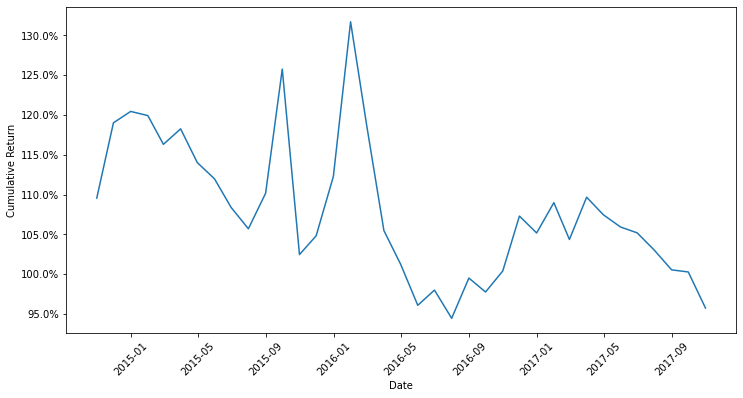

In [92]:
port.plot()

### Grid Search

In [ ]:
# #Set up Data
# price_data = pd.read_csv("../Data/sp500df.csv", index_col='Date')
# rfr = pd.DataFrame({'risk_free': [0.01]*len(price_data.index)}, index = price_data.index)
# data_set = Data(price_data, rfr)
# data_set.set_factor_returns()

# #Set Up Portfolio and Model
# port=Portfolio(data_set)

# #Set Up model
# start_date= "2014-10-31"
# end_date= "2017-11-01"
# lookback=20
# lookahead=5
# lam=0.9
# model=Model(lam)

# # Define constraints to use
# test = Backtest(start_date, end_date, lookback, lookahead)
# test.grid_search(data_set, port, model)

In [4]:
class FactorModel:
    def __init__(self, lookahead, lookback, regress_weighting):
        
        """
        lookahead: number of periods in the future to estimate
        lookback: number of periods in the past to use for estimations
        regress_weighting: array of size 4 with weight corresponding to each regression type; adds up to 1; 
        order is linear, lasso, ridge, SVR; in the case where there is one 1 and the rest 0's, there is no ensembling;
        can artifically call LSTM by setting all weights to 0
        """
        self.lookahead = lookahead
        self.lookback = lookback
        self.regress_weighting = regress_weighting
        return
               
    def get_param_estimate(self, rebal_date, data):
               
        if sum(self.regress_weighting) == 0:
            return self.get_mu_LSTM(rebal_date, data)

        elif sum(self.regress_weighting) == 1:
            return self.get_mu_Q_regression(rebal_date, data)
        
        else:
            return "ERROR: This regression weighting is not valid. Please make sure the weights sum to 1. You can also give all zeros for LSTM."
        
    def get_mu_Q_regression(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        lookahead = self.lookahead
        lookback = self.lookback
        regress_weighting = self.regress_weighting
                
        # For keeping track of mu's and Q's from each period
        mu_arr = []
        Q_arr = []

        n_factors = len(factor_data.columns)

        returns_data = data.get_lookback_data(returns_data, rebal_date, lookback)
        factor_data = data.get_lookback_data(factor_data, rebal_date, lookback)
        
        for i in range(0, lookahead):

            # Calculate the factor covariance matrix
            F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()

            # Calculate the factor expected excess return from historical data using the geometric mean
            factor_data['Ones'] = [1 for i in range(len(factor_data))]
            gmean = stats.gmean(factor_data + 1,axis=0) - 1

            # Set up X and Y to determine alpha and beta
            X = factor_data
            Y = returns_data
            X = X.to_numpy()
            Y = Y.to_numpy()

            
            ### LINEAR REGRESSION
        
            model = LinearRegression().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_linear = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_linear = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### LASSO REGRESSION

            model = Lasso().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_lasso = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_lasso = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### RIDGE REGRESSION

            model = Ridge().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_ridge = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_ridge = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### SUPPORT VECTOR REGRESSION

            model = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=1, dual=False, loss="squared_epsilon_insensitive"))).fit(X, Y)
            beta = np.array([[model.named_steps['multioutputregressor'].estimators_[i].coef_[0:n_factors] for i in range(len(model.named_steps['multioutputregressor'].estimators_))]])[0]
            alpha = np.array([model.named_steps['multioutputregressor'].estimators_[i].intercept_[0] for i in range(len(model.named_steps['multioutputregressor'].estimators_))])

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_SVR = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_SVR = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D

        
            # Ensemble the methods
            mu = regress_weighting[0]*mu_linear + regress_weighting[1]*mu_lasso + regress_weighting[2]*mu_ridge + regress_weighting[3]*mu_SVR
            Q = regress_weighting[0]*Q_linear + regress_weighting[1]*Q_lasso + regress_weighting[2]*Q_ridge + regress_weighting[3]*Q_SVR

            # Add mu and Q to array
            mu_arr.append(mu)
            Q_arr.append(Q)

            # Update for next time step
            factor_data = factor_data[1:]
            factor_append = pd.Series(gmean, index = factor_data.columns)
            factor_data = factor_data.append(factor_append, ignore_index=True)

            returns_data = returns_data[1:]
            mu_append = pd.Series(mu, index=returns_data.columns)
            returns_data = returns_data.append(mu_append, ignore_index=True)   

        return mu_arr, Q_arr
        
    def get_mu_LSTM(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        
        lookahead = self.lookahead
        lookback = self.lookback
        regress_weighting = self.regress_weighting

        returns_data = data.get_lookback_data(returns_data, rebal_date, lookback)
        factor_data = data.get_lookback_data(factor_data, rebal_date, lookback)
        
        tempx, tempy = self.generate_X_y(factor_data.values, returns_data.values, lookback, lookahead)
        train_x, test_x, train_y, test_y = self.traintest_split(tempx, tempy)

        # scale inputs
        scaled_train_x = (train_x - train_x.min())/(train_x.max() - train_x.min())
        scaled_test_x = (test_x - test_x.min())/(test_x.max() - test_x.min())
        scaled_train_y = (train_y - train_y.min())/(train_y.max() - train_y.min())
        scaled_test_y = (test_y - test_y.min())/(test_y.max() - test_y.min())

        mu = self.get_prediction(train_x, train_y, factor_data, lookback)
        return mu
    
    def generate_X_y(self, factor_data, returns_data, n_lookback, n_lookforward):
        X, y = list(), list()
        in_start = 0
        for i in range(len(factor_data)):
            in_end = in_start + n_lookback
            out_end = in_end + n_lookforward
            # ensure we have enough data for this instance
            if out_end <= len(factor_data):
                X.append(factor_data[in_start:in_end,:])
                y.append(returns_data[in_end:out_end,:])
            in_start += 1
        return np.array(X), np.array(y)
    
    def traintest_split(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test   
    
    def build_model(self, train_x, train_y):
        # define parameters
        verbose, epochs, batch_size = 0, 50, 16
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

        # define model
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(train_y.shape[2])))
        model.compile(loss='mse', optimizer='adam')
        # fit network
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return model
    
    def forecast(self, model, history, n_lookback):
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for lookback data
        input_x = data[-n_lookback:, :]
        # reshape into [1, n_lookback, n]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
        # forecast the next set
        yhat = model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def evaluate_forecasts(self, actual, predicted):
        # calculate overall RMSE
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                for k in range(actual.shape[2]):
                    s += (actual[row, col, k] - predicted[row, col, k])**2
        score = sqrt(s / (actual.shape[0] * actual.shape[1] * actual.shape[2]))
        return score

    def evaluate_model(self, train_x, train_y, test_x, test_y, n_lookback):
        # fit model
        model = self.build_model(train_x, train_y)
        history = [x for x in train_x]
        # walk-forward validation 
        predictions = list()
        for i in range(len(test_x)):
            yhat_sequence = self.forecast(model, history, n_lookback)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next set
            history.append(test_x[i, :])
        # evaluate predictions 
        predictions = np.array(predictions)
        score = self.evaluate_forecasts(test_y, predictions)
        plt.plot(model.history.history['loss'])
        #plt.plot(model.history.history['val_loss'])
        return score
    
    def get_prediction(self, train_x, train_y, factor_data, lookback):
        model = self.build_model(train_x, train_y)
        return self.forecast(model, factor_data.tail(lookback), lookback)
